![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

# **Entrega - Grupo 8**

Realizado por:
- Lady Tatiana Garcia Moreno
- Joaquin Abondano Araoz
- Edwin Ricardo Ramirez Calvijo
- Omar Leonardo Albarracin Monsalve

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Carga de datos

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pip install scikit-learn --quiet

In [3]:
# Importación librerías
import re, os, nltk
from nltk.corpus import stopwords
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
nltk.download('stopwords'), nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


(True, True)

In [5]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [6]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [8]:
dataTraining.shape, dataTesting.shape

((7895, 5), (3383, 3))

In [9]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [7]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

## Exploración de datos

In [11]:
dataTrainingvis=dataTraining.copy()

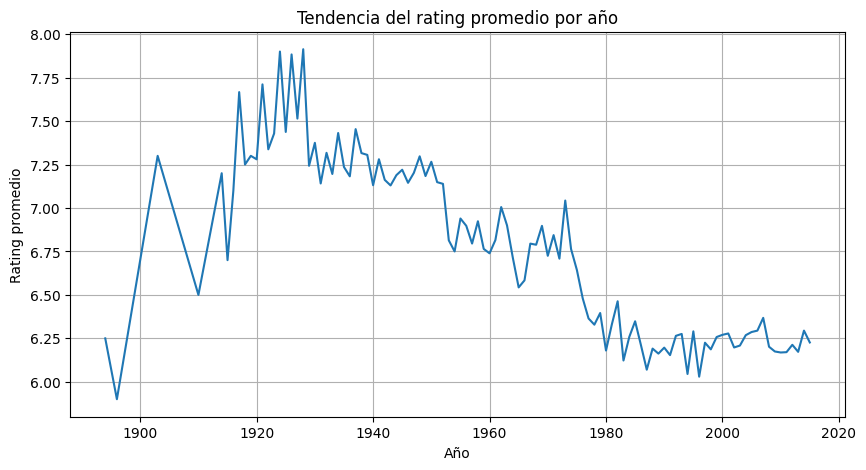

In [12]:
# Agrupamos por año y promediamos el rating
rating_por_año = dataTrainingvis.groupby('year')['rating'].mean().reset_index()

# Graficamos
plt.figure(figsize=(10, 5))
sns.lineplot(data=rating_por_año, x='year', y='rating')
plt.title('Tendencia del rating promedio por año')
plt.xlabel('Año')
plt.ylabel('Rating promedio')
plt.grid(True)
plt.show()

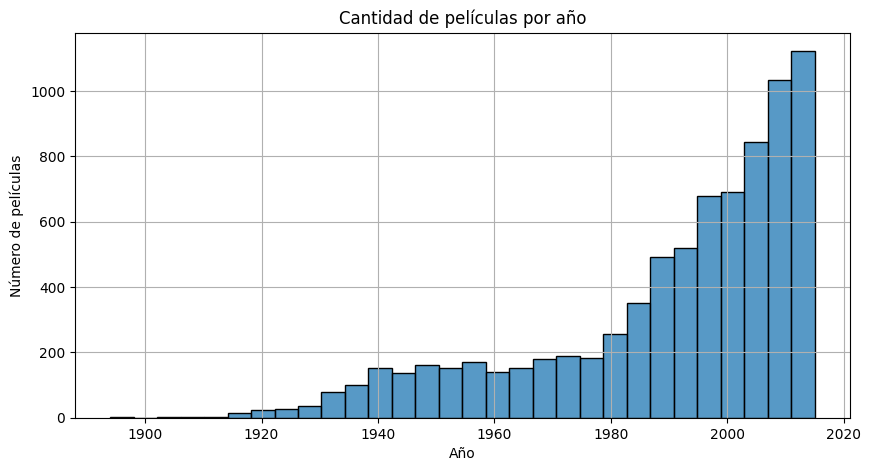

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(dataTrainingvis['year'], bins=30, kde=False)
plt.title('Cantidad de películas por año')
plt.xlabel('Año')
plt.ylabel('Número de películas')
plt.grid(True)
plt.show()


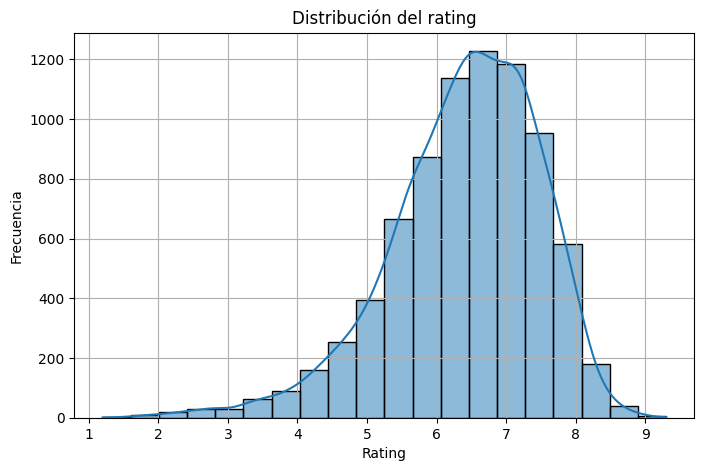

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(dataTrainingvis['rating'], bins=20, kde=True)
plt.title('Distribución del rating')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


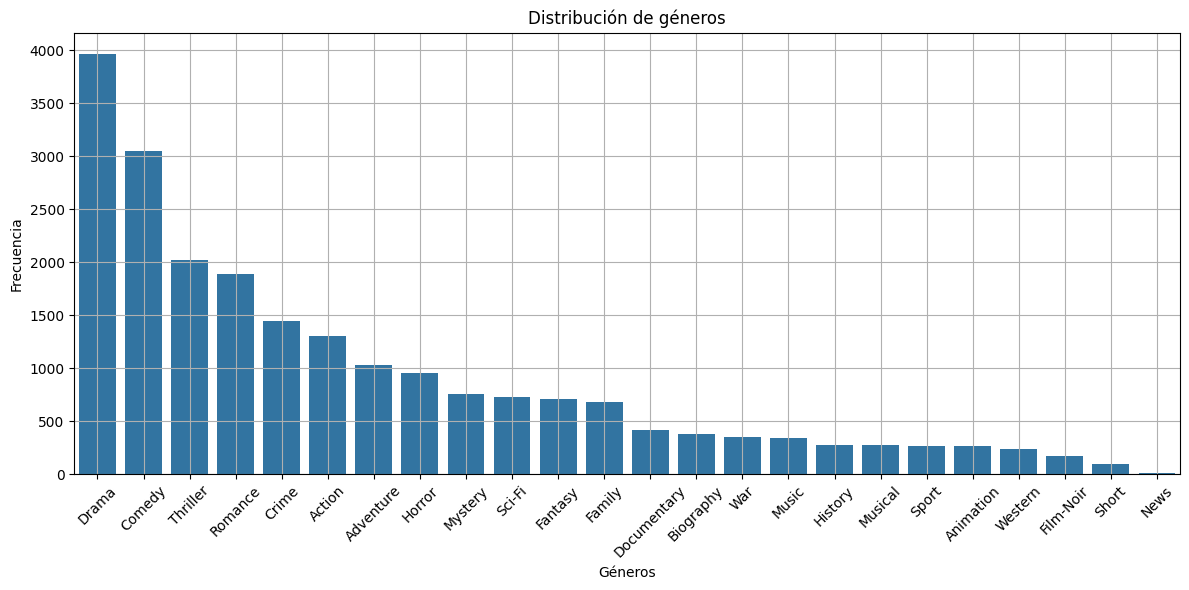

In [15]:
# Gráfica de géneros
#pasar de cadena de listas a listas: "["Drama","Comedy"]" -- > ["Drama","Comedy"]

dataTrainingvis['genres'] = dataTrainingvis['genres'].apply(eval)

# Explota la columna una sola vez
exploded = dataTrainingvis.explode('genres')

# Graficar la frecuencia de cada género
plt.figure(figsize=(12, 6))
sns.countplot(data=exploded, x='genres', order=exploded['genres'].value_counts().index)
plt.title('Distribución de géneros')
plt.xlabel('Géneros')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# Validacion datos faltantes
print("Faltantes en data entrenamiento:")
print(dataTrainingvis.isnull().sum())
print("\nFaltantes en data test:")
print(dataTesting.isnull().sum())

Faltantes en data entrenamiento:
year      0
title     0
plot      0
genres    0
rating    0
dtype: int64

Faltantes en data test:
year     0
title    0
plot     0
dtype: int64


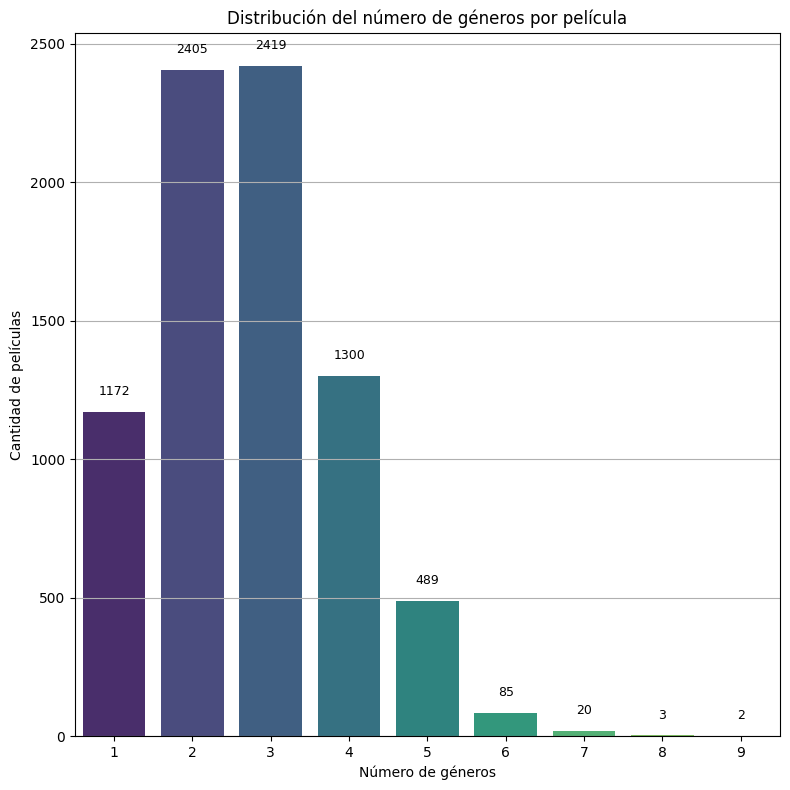

In [17]:
# Contar cuántos géneros tiene cada película
genre_counts = dataTrainingvis['genres'].apply(lambda x: len(x)).value_counts().sort_index()

# Crear gráfico de barras
plt.figure(figsize=(8, 8))
ax = sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')

# Agregar valores sobre cada barra
for i, value in enumerate(genre_counts.values):
    ax.text(i, value + 50, str(value), ha='center', va='bottom', fontsize=9)

# Etiquetas y estilo
plt.title('Distribución del número de géneros por película')
plt.xlabel('Número de géneros')
plt.ylabel('Cantidad de películas')
plt.grid(axis='y')


plt.tight_layout()
plt.show()

count    7895.000000
mean      126.613173
std        84.401482
min         1.000000
10%        40.000000
25%        70.000000
50%       110.000000
75%       161.000000
90%       240.000000
max      1723.000000
Name: n_palabras, dtype: float64
count    7895.000000
mean        0.711173
std         0.109686
min         0.326756
25%         0.631662
50%         0.705882
75%         0.782609
max         1.000000
Name: riqueza, dtype: float64


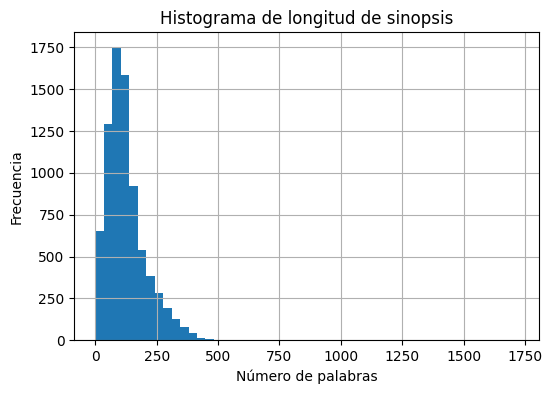

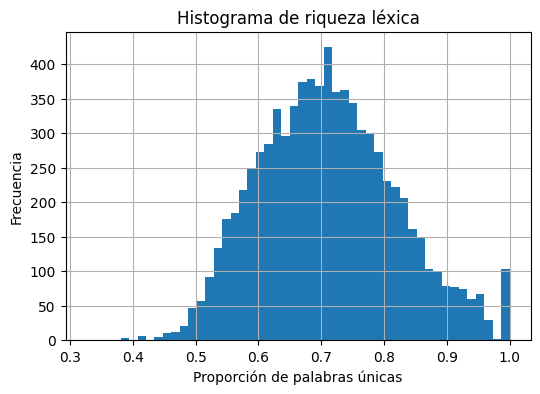

In [19]:
df = dataTrainingvis.copy()

# Tokenización básica: minúsculas y palabras alfanuméricas
def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

df['tokens'] = df['plot'].apply(tokenize)

# Estadísticos de longitud
df['n_palabras'] = df['tokens'].apply(len)
print(df['n_palabras'].describe(percentiles=[.1, .25, .5, .75, .9]))

# Riqueza léxica
df['n_unicos'] = df['tokens'].apply(lambda t: len(set(t)))
df['riqueza'] = df['n_unicos'] / df['n_palabras']
print(df['riqueza'].describe())

# Visualizaciones
plt.figure(figsize=(6,4))
plt.hist(df['n_palabras'], bins=50)
plt.title('Histograma de longitud de sinopsis')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df['riqueza'], bins=50)
plt.title('Histograma de riqueza léxica')
plt.xlabel('Proporción de palabras únicas')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

## Tratamiento de variables

### Eliminación de valores duplicados

In [8]:
import ast

# Convierte los strings en listas
dataTraining['genres'] = dataTraining['genres'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Convierte a tuplas (listas no son hashables)
dataTraining['genres'] = dataTraining['genres'].apply(
    lambda x: tuple(x) if isinstance(x, list) else x
)
print('duplicados: ',dataTraining.duplicated().sum())
# Elimina duplicados
dataTraining = dataTraining.drop_duplicates()

# Si lo necesitas como listas nuevamente
dataTraining['genres'] = dataTraining['genres'].apply(
    lambda x: list(x) if isinstance(x, tuple) else x
)

print(dataTraining['genres'].head())

duplicados:  1
3107                  [Short, Drama]
900          [Comedy, Crime, Horror]
6724    [Drama, Film-Noir, Thriller]
4704                         [Drama]
2582       [Action, Crime, Thriller]
Name: genres, dtype: object


### Eliminación de caracteres extraños y convertir a minúsculas todos los carcteres

In [9]:
def remove_tags(string):
    removelist = ""
    p = re.compile(r'<.*?>')
    result = p.sub('',string) #remove HTML tags
    result = re.sub(r'http\S+', '',result) #remove URLs
    result = re.sub(r'[\W_'+removelist+']', ' ', result) #remove non-alphanumeric characters
    result = result.lower()
    return result
dataTraining['plot']=dataTraining['plot'].apply(lambda cw : remove_tags(cw))
dataTraining

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"[Short, Drama]",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"[Comedy, Crime, Horror]",5.6
6724,1941,A Woman's Face,in sweden a female blackmailer with a disfi...,"[Drama, Film-Noir, Thriller]",7.2
4704,1954,Executive Suite,in a friday afternoon in new york the presi...,[Drama],7.4
2582,1990,Narrow Margin,in los angeles the editor of a publishing h...,"[Action, Crime, Thriller]",6.6
...,...,...,...,...,...
8417,2010,Our Family Wedding,our marriage their wedding it s l...,"[Comedy, Romance]",4.9
1592,1984,Conan the Destroyer,the wandering barbarian conan alongside ...,"[Action, Adventure, Fantasy]",5.8
1723,1955,Kismet,like a tale spun by scheherazade kismet fol...,"[Adventure, Musical, Fantasy, Comedy, Romance]",6.4
7605,1982,The Secret of NIMH,mrs brisby a widowed mouse lives in a...,"[Animation, Adventure, Drama, Family, Fantasy,...",7.6


In [10]:
# Eliminacion de etiquetas en test
dataTesting['plot']=dataTesting['plot'].apply(lambda cw : remove_tags(cw))

In [11]:
# Validar si hay valores vacios en plot
num_vacios = (dataTraining['plot'].str.strip() == '').sum()
print(f"Número de valores vacíos en 'plot': {num_vacios}")

Número de valores vacíos en 'plot': 0


### Eliminación de stopwords

In [12]:
stop_words = set(stopwords.words('english'))
dataTraining['plot'] = dataTraining['plot'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

dataTesting['plot'] = dataTesting['plot'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
dataTraining

,year,title,plot,genres,rating
3107,2003,Most,story single father takes eight year old son w...,"[Short, Drama]",8.0
900,2008,How to Be a Serial Killer,serial killer decides teach secrets satisfying...,"[Comedy, Crime, Horror]",5.6
6724,1941,A Woman's Face,sweden female blackmailer disfiguring facial s...,"[Drama, Film-Noir, Thriller]",7.2
4704,1954,Executive Suite,friday afternoon new york president tredway co...,[Drama],7.4
2582,1990,Narrow Margin,los angeles editor publishing house carol hunn...,"[Action, Crime, Thriller]",6.6
...,...,...,...,...,...
8417,2010,Our Family Wedding,marriage wedding lesson number one newly engag...,"[Comedy, Romance]",4.9
1592,1984,Conan the Destroyer,wandering barbarian conan alongside goofy rogu...,"[Action, Adventure, Fantasy]",5.8
1723,1955,Kismet,like tale spun scheherazade kismet follows rem...,"[Adventure, Musical, Fantasy, Comedy, Romance]",6.4
7605,1982,The Secret of NIMH,mrs brisby widowed mouse lives cinder block ch...,"[Animation, Adventure, Drama, Family, Fantasy,...",7.6


### Lematización

In [13]:
#AQUI
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
dataTraining['plot'] = dataTraining['plot'].apply(lemmatize_text)

dataTesting['plot'] = dataTesting['plot'].apply(lemmatize_text)

### Transformar y definir variable de interés - géneros

In [14]:
# Transformación y definición de la variable de interés genres
le = MultiLabelBinarizer()
y = le.fit_transform(dataTraining['genres'])
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

## División en entrenamiento y validación

In [15]:
# Division de datos en entrenamiento y prueba
X_train, X_val, y_train, y_val = train_test_split(dataTraining['plot'], y, test_size=0.2, random_state=42)

## Búsqueda de mejor modelo

### TFIDF + Logistic Regression v1

In [ ]:
# 3. Pipeline de texto + modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight='balanced',random_state=42, n_jobs=-1)))
])



# 4. Definición de la grilla de búsqueda
param_grid = {
    'clf__estimator__max_iter': [100, 200, 500],
    'clf__estimator__C': [0.01, 1, 5],
    'clf__estimator__penalty': ['l2'],
    'clf__estimator__solver': ['liblinear', 'saga'],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # unigramas, bigramas y trigramas
    'tfidf__max_features': [20000, 25000],  # número de características
}

# 5. Búsqueda con validación cruzada
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 6. Entrenamiento
grid_search.fit(X_train, y_train)

# 7. Mejor modelo
print("Mejores parámetros:")
print(grid_search.best_params_)

# 8. Evaluación en conjunto de validación
y_val_pred = grid_search.predict_proba(X_val)
print("ROC AUC (macro):", roc_auc_score(y_val, y_val_pred, average='macro'))



Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [ ]:
# 9. Predicciones sobre dataTesting (para Kaggle)
X_final = dataTesting['plot']  # o 'plot' si no usaste lematización

# Utiliza el mejor modelo encontrado por GridSearchCV
best_model = grid_search.best_estimator_

# Generar las predicciones
y_pred_final = best_model.predict_proba(X_final)


In [ ]:
res = pd.DataFrame(y_pred_final, index=dataTesting.index, columns=cols)
res.to_csv('pred_tfidf_lr1.csv', index_label='ID')

In [ ]:
# Convertir resultados del grid en DataFrame
resultslr = pd.DataFrame(grid_search.cv_results_)

# Ordenar por la métrica de evaluación (roc_auc en validación)
resultslr_sorted = resultslr.sort_values(by='mean_test_score', ascending=False)

# Seleccionar los 5 mejores
top5lgr = resultslr_sorted.head(5)
top5lgr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator__C,param_clf__estimator__max_iter,param_clf__estimator__penalty,param_clf__estimator__solver,param_tfidf__max_features,param_tfidf__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
40,5.951122,0.266865,0.646398,0.050370,1.0,100,l2,liblinear,25000,"(1, 2)","{'clf__estimator__C': 1, 'clf__estimator__max_...",0.876289,0.883235,0.882368,0.880631,0.003091,1
52,5.797366,0.336458,0.571993,0.019209,1.0,200,l2,liblinear,25000,"(1, 2)","{'clf__estimator__C': 1, 'clf__estimator__max_...",0.876289,0.883235,0.882368,0.880631,0.003091,1
64,5.178934,0.159303,0.564115,0.032664,1.0,500,l2,liblinear,25000,"(1, 2)","{'clf__estimator__C': 1, 'clf__estimator__max_...",0.876289,0.883235,0.882368,0.880631,0.003091,1
41,9.239541,0.102787,0.984611,0.283372,1.0,100,l2,liblinear,25000,"(1, 3)","{'clf__estimator__C': 1, 'clf__estimator__max_...",0.875981,0.883010,0.882149,0.880380,0.003131,4
53,8.285020,0.107962,0.894786,0.026213,1.0,200,l2,liblinear,25000,"(1, 3)","{'clf__estimator__C': 1, 'clf__estimator__max_...",0.875981,0.883010,0.882149,0.880380,0.003131,4


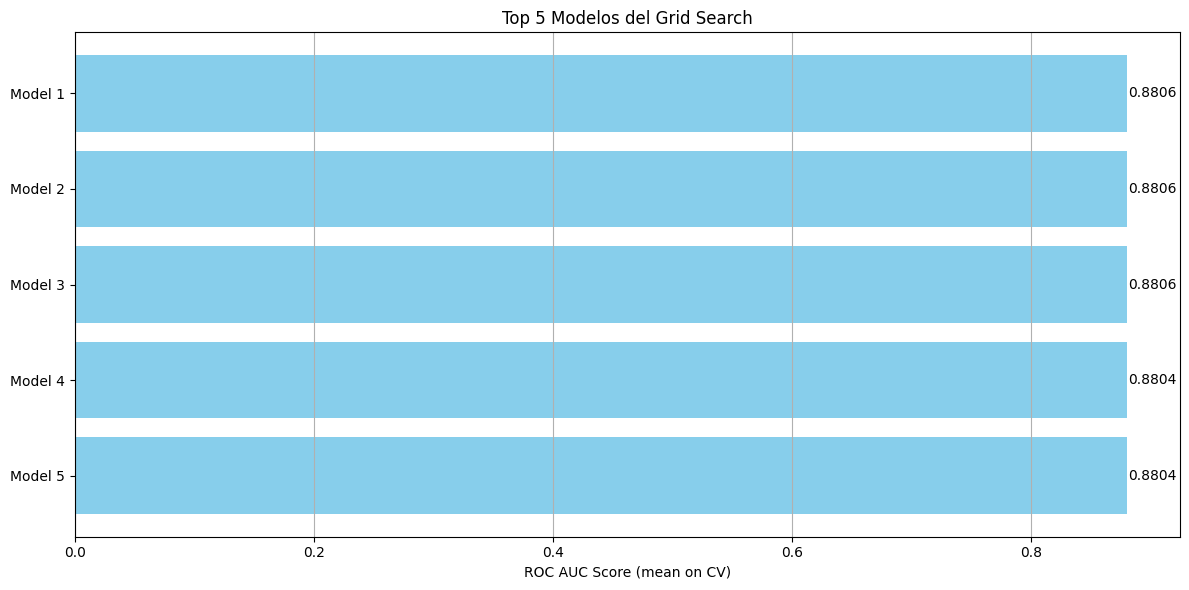

In [ ]:
plt.figure(figsize=(12, 6))
bars = plt.barh(range(5), top5lgr['mean_test_score'], align='center', color='skyblue')
plt.yticks(range(5), [f"Model {i+1}" for i in range(5)])
plt.xlabel('ROC AUC Score (mean on CV)')
plt.title('Top 5 Modelos del Grid Search')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()

# Añadir texto con el valor en cada barra
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', va='center')

plt.show()

In [ ]:
for i, row in top5lgr.iterrows():
    print(f"\nModelo {i+1} - ROC AUC: {row['mean_test_score']:.4f}")
    for param, value in row.items():
        if param.startswith('param_'):
            print(f"  {param[6:]}: {value}")


Modelo 41 - ROC AUC: 0.8806
  clf__estimator__C: 1.0
  clf__estimator__max_iter: 100
  clf__estimator__penalty: l2
  clf__estimator__solver: liblinear
  tfidf__max_features: 25000
  tfidf__ngram_range: (1, 2)

Modelo 53 - ROC AUC: 0.8806
  clf__estimator__C: 1.0
  clf__estimator__max_iter: 200
  clf__estimator__penalty: l2
  clf__estimator__solver: liblinear
  tfidf__max_features: 25000
  tfidf__ngram_range: (1, 2)

Modelo 65 - ROC AUC: 0.8806
  clf__estimator__C: 1.0
  clf__estimator__max_iter: 500
  clf__estimator__penalty: l2
  clf__estimator__solver: liblinear
  tfidf__max_features: 25000
  tfidf__ngram_range: (1, 2)

Modelo 42 - ROC AUC: 0.8804
  clf__estimator__C: 1.0
  clf__estimator__max_iter: 100
  clf__estimator__penalty: l2
  clf__estimator__solver: liblinear
  tfidf__max_features: 25000
  tfidf__ngram_range: (1, 3)

Modelo 54 - ROC AUC: 0.8804
  clf__estimator__C: 1.0
  clf__estimator__max_iter: 200
  clf__estimator__penalty: l2
  clf__estimator__solver: liblinear
  tfidf_

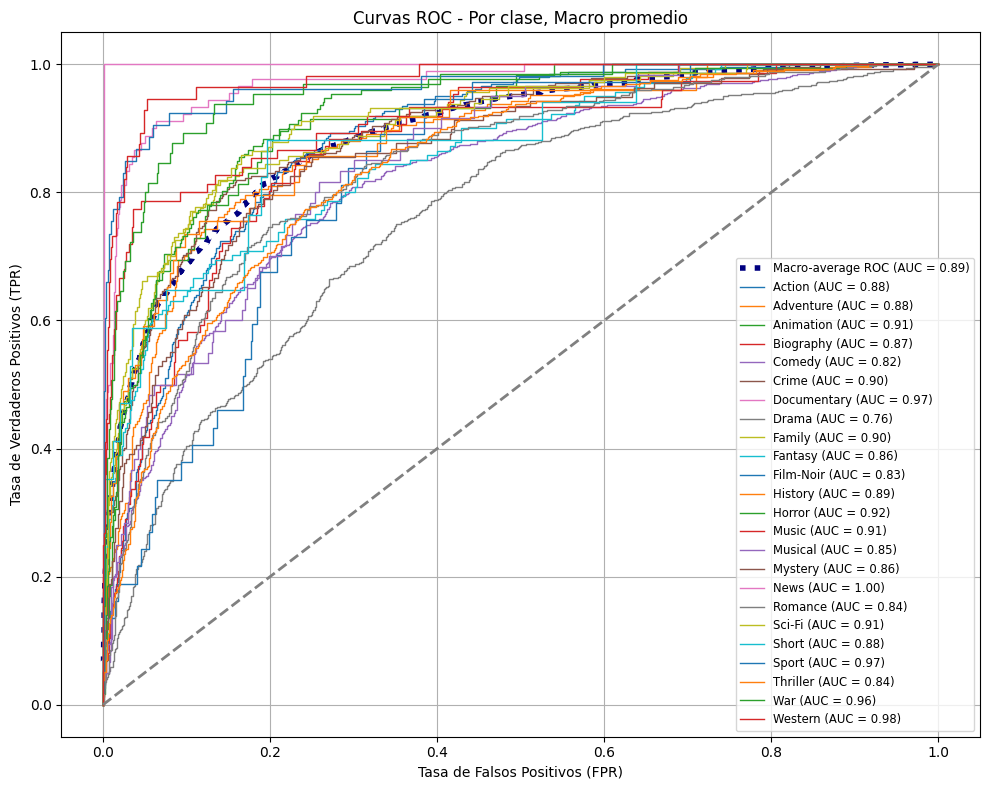

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_val_pred.shape[1]
class_names = le.classes_

# Por clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro
# 1. Interpolar todas las curvas
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))


plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

# Curvas individuales
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})',
             lw=1)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC - Por clase, Macro promedio')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

### TFIDF + Logistic Regression v2

In [16]:
## Calibración de hiperparámetros con logistic regression y trigramas,unigramas y bigramas y lematización
# 1. Procesamiento etiquetas
#dataTraining['genres'] = dataTraining['genres'].apply(eval)
import nltk

# probar modelo con mejores pa´rametros dados por gridsearch y lematización
#dataTraining['genres'] = dataTraining['genres'].apply(eval)
nltk.download('wordnet')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st

dataTraining['plot_lemmatized'] = dataTraining['plot'].apply(lemmatize_text)
dataTesting['plot_lemmatized'] = dataTesting['plot'].apply(lemmatize_text)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataTraining['genres'])

# 2. División inicial (para no hacer CV sobre todo el set)
X_train, X_val, y_train, y_val = train_test_split(
    dataTraining['plot_lemmatized'], y, test_size=0.2, random_state=42)

# 3. Pipeline de texto + modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight='balanced',random_state=42, n_jobs=-1)))
])



# 4. Definición de la grilla de búsqueda
param_grid = {
    'clf__estimator__max_iter': [100, 200, 500],
    'clf__estimator__C': [0.01, 1, 5],
    'clf__estimator__penalty': ['l2'],
    'clf__estimator__solver': ['liblinear', 'saga'],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # unigramas, bigramas y trigramas
    'tfidf__max_features': [20000, 25000],  # número de características
}

# 5. Búsqueda con validación cruzada
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=10,
    verbose=2,
    n_jobs=-1
)

# 6. Entrenamiento
grid_search.fit(X_train, y_train)

# 7. Mejor modelo
print("Mejores parámetros:")
print(grid_search.best_params_)

# 8. Evaluación en conjunto de validación
y_val_pred = grid_search.predict_proba(X_val)
print("ROC AUC (macro):", roc_auc_score(y_val, y_val_pred, average='macro'))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Fitting 10 folds for each of 108 candidates, totalling 1080 fits


KeyboardInterrupt: 

In [ ]:
# Convertir resultados del grid en DataFrame
resultslr = pd.DataFrame(grid_search.cv_results_)

# Ordenar por la métrica de evaluación (roc_auc en validación)
resultslr_sorted = resultslr.sort_values(by='mean_test_score', ascending=False)

# Seleccionar los 5 mejores
top5lgr = resultslr_sorted.head(5)

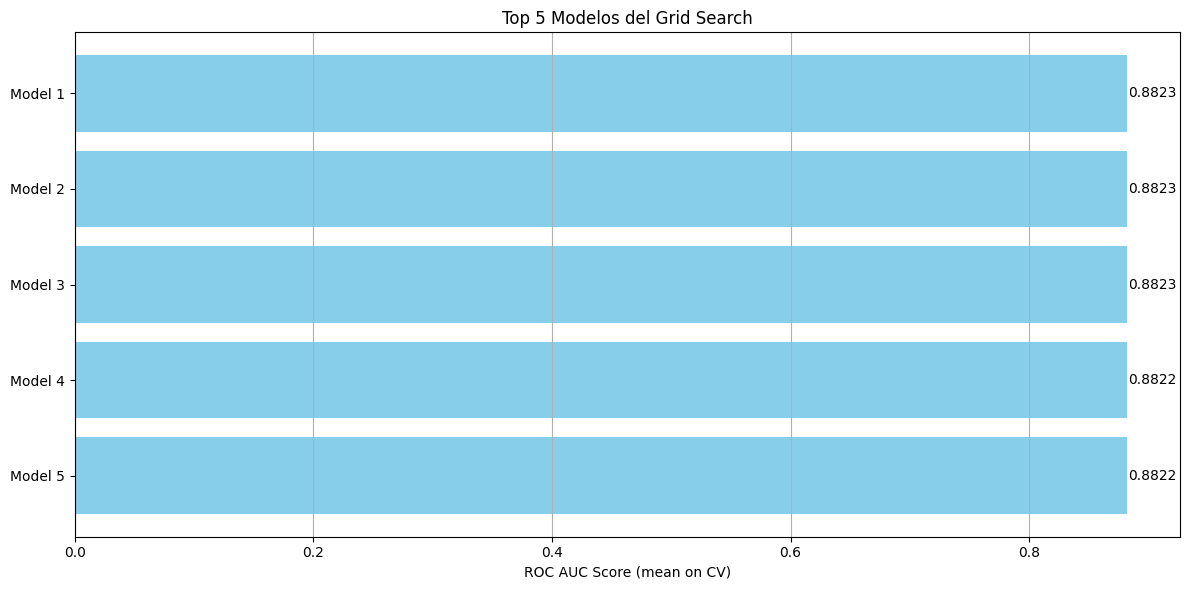

In [ ]:
plt.figure(figsize=(12, 6))
bars = plt.barh(range(5), top5lgr['mean_test_score'], align='center', color='skyblue')
plt.yticks(range(5), [f"Model {i+1}" for i in range(5)])
plt.xlabel('ROC AUC Score (mean on CV)')
plt.title('Top 5 Modelos del Grid Search')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()

# Añadir texto con el valor en cada barra
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', va='center')

plt.show()

In [ ]:
for i, row in top5lgr.iterrows():
    print(f"\nModelo {i+1} - ROC AUC: {row['mean_test_score']:.4f}")
    for param, value in row.items():
        if param.startswith('param_'):
            print(f"  {param[6:]}: {value}")


Modelo 135 - ROC AUC: 0.8823
  clf__estimator__C: 1.0
  clf__estimator__max_iter: 100
  clf__estimator__penalty: l2
  clf__estimator__solver: liblinear
  tfidf__max_features: 20000
  tfidf__ngram_range: (1, 3)

Modelo 171 - ROC AUC: 0.8823
  clf__estimator__C: 1.0
  clf__estimator__max_iter: 200
  clf__estimator__penalty: l2
  clf__estimator__solver: liblinear
  tfidf__max_features: 20000
  tfidf__ngram_range: (1, 3)

Modelo 207 - ROC AUC: 0.8823
  clf__estimator__C: 1.0
  clf__estimator__max_iter: 500
  clf__estimator__penalty: l2
  clf__estimator__solver: liblinear
  tfidf__max_features: 20000
  tfidf__ngram_range: (1, 3)

Modelo 170 - ROC AUC: 0.8822
  clf__estimator__C: 1.0
  clf__estimator__max_iter: 200
  clf__estimator__penalty: l2
  clf__estimator__solver: liblinear
  tfidf__max_features: 20000
  tfidf__ngram_range: (1, 2)

Modelo 134 - ROC AUC: 0.8822
  clf__estimator__C: 1.0
  clf__estimator__max_iter: 100
  clf__estimator__penalty: l2
  clf__estimator__solver: liblinear
  t

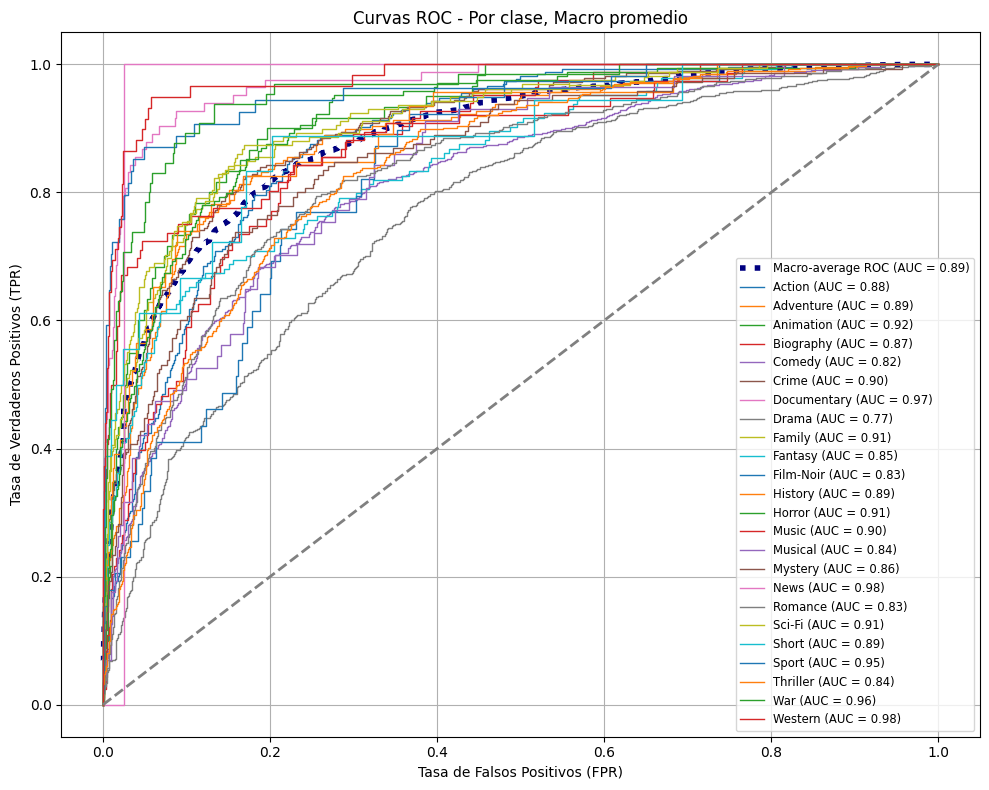

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_val_pred.shape[1]
class_names = mlb.classes_

# Por clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro
# 1. Interpolar todas las curvas
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))


plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

# Curvas individuales
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})',
             lw=1)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC - Por clase, Macro promedio')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

Ejecución de modelo con los mejores parámetros

In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st

dataTraining['plot_lemmatized'] = dataTraining['plot'].apply(lemmatize_text)
dataTesting['plot_lemmatized'] = dataTesting['plot'].apply(lemmatize_text)


mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataTraining['genres'])



# Paso 2: TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=20000, ngram_range=(1, 3))
X = tfidf.fit_transform(dataTraining['plot_lemmatized'])

# Paso 3: División
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Paso 4: Modelo
clf = OneVsRestClassifier(LogisticRegression(max_iter=100, random_state=42,n_jobs=-1, C=1, penalty='l2', solver='liblinear'))
clf.fit(X_train, y_train)


# Paso 5: Evaluación
y_pred = clf.predict_proba(X_test)
print('ROC AUC (macro):', roc_auc_score(y_test, y_pred, average='macro'))

# Paso 6: Predicciones para Kaggle
X_final = tfidf.transform(dataTesting['plot_lemmatized'])
y_pred_final = clf.predict_proba(X_final)

ROC AUC (macro): 0.880902796650252


In [ ]:
res = pd.DataFrame(y_pred_final, index=dataTesting.index, columns=cols)
res.to_csv('pred_tfidf_lrtrigrama.csv', index_label='ID')
##Valor Kaggle 0.88804-- mejor hasta ahora

Corriendo el modelo con class_weight_balance= balanced, el roc auc disminuye

In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st

dataTraining['plot_lemmatized'] = dataTraining['plot'].apply(lemmatize_text)
dataTesting['plot_lemmatized'] = dataTesting['plot'].apply(lemmatize_text)


mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataTraining['genres'])

# Paso 2: TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=20000, ngram_range=(1, 3))
X = tfidf.fit_transform(dataTraining['plot_lemmatized'])

# Paso 3: División
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Paso 4: Modelo
clf = OneVsRestClassifier(LogisticRegression(class_weight='balanced',max_iter=100, random_state=42,n_jobs=-1, C=1, penalty='l2', solver='liblinear'))
clf.fit(X_train, y_train)


# Paso 5: Evaluación
y_pred = clf.predict_proba(X_test)
print('ROC AUC (macro):', roc_auc_score(y_test, y_pred, average='macro'))

# Paso 6: Predicciones para Kaggle
X_final = tfidf.transform(dataTesting['plot_lemmatized'])
y_pred_final = clf.predict_proba(X_final)

ROC AUC (macro): 0.8794463859583042


### TFIDF + Logistic Regresion vf

In [ ]:
# 3. Pipeline de texto + modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', OneVsRestClassifier(LogisticRegression(random_state=42, n_jobs=-1)))
])



# 4. Definición de la grilla de búsqueda
param_grid = {
    'clf__estimator__max_iter': [100, 200, 500],
    'clf__estimator__C': [0.01, 1, 5],
    'clf__estimator__penalty': ['l2'],
    'clf__estimator__solver': ['liblinear', 'saga'],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # unigramas, bigramas y trigramas
    'tfidf__max_features': [20000, 25000, 30000],  # número de características
}

# 5. Búsqueda con validación cruzada
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 6. Entrenamiento
grid_search.fit(X_train, y_train)

# 7. Mejor modelo
print("Mejores parámetros:")
print(grid_search.best_params_)

# 8. Evaluación en conjunto de validación
y_val_pred = grid_search.predict_proba(X_val)
print("ROC AUC (macro):", roc_auc_score(y_val, y_val_pred, average='macro'))

Fitting 3 folds for each of 162 candidates, totalling 486 fits


In [ ]:
# 9. Predicciones sobre dataTesting (para Kaggle)
X_final = dataTesting['plot']

# Utiliza el mejor modelo encontrado por GridSearchCV
best_model = grid_search.best_estimator_

# Generar las predicciones
y_pred_final = best_model.predict_proba(X_final)


In [ ]:
res = pd.DataFrame(y_pred_final, index=dataTesting.index, columns=cols)
res.to_csv('pred_tfidf_lr7.csv', index_label='ID')

In [ ]:
# Convertir resultados del grid en DataFrame
resultslr = pd.DataFrame(grid_search.cv_results_)

# Ordenar por la métrica de evaluación (roc_auc en validación)
resultslr_sorted = resultslr.sort_values(by='mean_test_score', ascending=False)

# Seleccionar los 5 mejores
top5lgr = resultslr_sorted.head(5)
top5lgr

In [ ]:
plt.figure(figsize=(12, 6))
bars = plt.barh(range(5), top5lgr['mean_test_score'], align='center', color='skyblue')
plt.yticks(range(5), [f"Model {i+1}" for i in range(5)])
plt.xlabel('ROC AUC Score (mean on CV)')
plt.title('Top 5 Modelos del Grid Search')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()

# Añadir texto con el valor en cada barra
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', va='center')

plt.show()

In [ ]:
for i, row in top5lgr.iterrows():
    print(f"\nModelo {i+1} - ROC AUC: {row['mean_test_score']:.4f}")
    for param, value in row.items():
        if param.startswith('param_'):
            print(f"  {param[6:]}: {value}")

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_val_pred.shape[1]
class_names = le.classes_

# Por clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro
# 1. Interpolar todas las curvas
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))


plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

# Curvas individuales
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})',
             lw=1)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC - Por clase, Macro promedio')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

### Random Forest

In [ ]:
## Calibración de hiperparámetros
# 1. Procesamiento etiquetas
#dataTraining['genres'] = dataTraining['genres'].apply(eval)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataTraining['genres'])

# 2. División inicial (para no hacer CV sobre todo el set)
X_train, X_val, y_train, y_val = train_test_split(
    dataTraining['plot'], y, test_size=0.2, random_state=42)

# 3. Pipeline de texto + modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('clf', OneVsRestClassifier(RandomForestClassifier(random_state=42, n_jobs=-1)))
])

# 4. Definición de la grilla de búsqueda
param_grid = {
    'clf__estimator__n_estimators': [50,100, 200],
    'clf__estimator__max_depth': [5,10, 20,50,100],
    'clf__estimator__min_samples_split': [2, 5,10,15],
    'clf__estimator__min_samples_leaf': [1, 2, 3]
}

# 5. Búsqueda con validación cruzada
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 6. Entrenamiento
grid_search.fit(X_train, y_train)

# 7. Mejor modelo
print("Mejores parámetros:")
print(grid_search.best_params_)

# 8. Evaluación en conjunto de validación
y_val_pred = grid_search.predict_proba(X_val)
print("ROC AUC (macro):", roc_auc_score(y_val, y_val_pred, average='macro'))


Fitting 3 folds for each of 180 candidates, totalling 540 fits
Mejores parámetros:
{'clf__estimator__max_depth': 50, 'clf__estimator__min_samples_leaf': 3, 'clf__estimator__min_samples_split': 10, 'clf__estimator__n_estimators': 200}
ROC AUC (macro): 0.8381194223956618


In [ ]:
# probar modelo con mejores pa´rametros dados por gridsearch
#dataTraining['genres'] = dataTraining['genres'].apply(eval)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataTraining['genres'])

# Paso 2: TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(dataTraining['plot'])

# Paso 3: División
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Paso 4: Modelo
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=50,min_samples_leaf=3,min_samples_split=10, random_state=42))
clf.fit(X_train, y_train)

# Paso 5: Evaluación
y_pred = clf.predict_proba(X_test)
print('ROC AUC (macro):', roc_auc_score(y_test, y_pred, average='macro'))

# Paso 6: Predicciones para Kaggle
X_final = tfidf.transform(dataTesting['plot'])
y_pred_final = clf.predict_proba(X_final)

ROC AUC (macro): 0.8283152886822119


### TFIDF y RidgeClassifier

In [ ]:
from sklearn.linear_model import RidgeClassifier
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st

dataTraining['plot_lemmatized'] = dataTraining['plot'].apply(lemmatize_text)
dataTesting['plot_lemmatized'] = dataTesting['plot'].apply(lemmatize_text)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataTraining['genres'])

# 2. División inicial (para no hacer CV sobre todo el set)
X_train, X_val, y_train, y_val = train_test_split(
    dataTraining['plot_lemmatized'], y, test_size=0.2, random_state=42)

# 3. Pipeline de texto + modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', OneVsRestClassifier(RidgeClassifier(random_state=42)))
])



# 4. Definición de la grilla de búsqueda para TFIDF + RidgeClassifier
param_grid = {
    'clf__estimator__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
    'clf__estimator__tol': [1e-3, 1e-4],
    'tfidf__max_features': [10000, 20000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__min_df': [1, 2],
    'tfidf__norm': ['l2', None]
}

# 5. Búsqueda con validación cruzada
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 6. Entrenamiento
grid_search.fit(X_train, y_train)

# 7. Mejor modelo
print("Mejores parámetros:")
print(grid_search.best_params_)

# 8. Evaluación en conjunto de validación
y_val_pred = grid_search.decision_function(X_val)
print("ROC AUC (macro):", roc_auc_score(y_val, y_val_pred, average='macro'))

Fitting 3 folds for each of 240 candidates, totalling 720 fits
Mejores parámetros:
{'clf__estimator__alpha': 10.0, 'clf__estimator__tol': 0.001, 'tfidf__max_features': 20000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3), 'tfidf__norm': 'l2'}
ROC AUC (macro): 0.888129986283592


In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st

dataTraining['plot_lemmatized'] = dataTraining['plot'].apply(lemmatize_text)
dataTesting['plot_lemmatized'] = dataTesting['plot'].apply(lemmatize_text)


mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataTraining['genres'])

# Paso 2: TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=20000, ngram_range=(1, 3),norm='l2')
X = tfidf.fit_transform(dataTraining['plot_lemmatized'])

# Paso 3: División
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Paso 4: Modelo
clf = OneVsRestClassifier(RidgeClassifier(alpha=10.0, tol=0.001, random_state=42))
clf.fit(X_train, y_train)


# Paso 5: Evaluación
y_pred = clf.decision_function(X_test)
print('ROC AUC (macro):', roc_auc_score(y_test, y_pred, average='macro'))

# Paso 6: Predicciones para Kaggle
X_final = tfidf.transform(dataTesting['plot_lemmatized'])
y_pred_final = clf.decision_function(X_final)

ROC AUC (macro): 0.8755340435823435


In [ ]:
res = pd.DataFrame(y_pred_final, index=dataTesting.index, columns=cols)
res.to_csv('pred_tfidf_ridgeClassifier.csv', index_label='ID')

### Feature union

Agregar columna de tamaño de frase... no aporta al problema, el rorc auc no mejoró

In [ ]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st

dataTraining['plot_lemmatized'] = dataTraining['plot'].apply(lemmatize_text)
dataTesting['plot_lemmatized'] = dataTesting['plot'].apply(lemmatize_text)


mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataTraining['genres'])


# Paso 3: División
X_train, X_test, y_train, y_test = train_test_split(dataTraining['plot_lemmatized'], y, test_size=0.33, random_state=42)

def text_length(X):
    return np.array([len(text.split()) for text in X]).reshape(-1, 1)

combined_features = FeatureUnion([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=20000, ngram_range=(1, 3))),
    ('length', FunctionTransformer(text_length, validate=False))
])

pipeline = Pipeline([
    ('features', combined_features),
    ('clf', OneVsRestClassifier(LogisticRegression(
        C=1, solver='liblinear', penalty='l2', max_iter=100, class_weight='balanced', n_jobs=-1
    )))
])

pipeline.fit(X_train, y_train)


# Paso 5: Evaluación
y_pred = pipeline.predict_proba(X_test)
print('ROC AUC (macro):', roc_auc_score(y_test, y_pred, average='macro'))

# Paso 6: Predicciones para Kaggle
X_final = dataTesting['plot_lemmatized']
y_pred_final = pipeline.predict_proba(X_final)

ROC AUC (macro): 0.8750500797257846


### Naive Bayes

In [ ]:
from sklearn.naive_bayes import ComplementNB

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st

dataTraining['plot_lemmatized'] = dataTraining['plot'].apply(lemmatize_text)
dataTesting['plot_lemmatized'] = dataTesting['plot'].apply(lemmatize_text)


mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataTraining['genres'])



# Paso 3: División
X_train, X_test, y_train, y_test = train_test_split(dataTraining['plot_lemmatized'], y, test_size=0.33, random_state=42)
# 3. Pipeline de texto + modelo
pipeline = Pipeline([
    ('count_vec', CountVectorizer(stop_words='english')),
    ('clf', OneVsRestClassifier(ComplementNB()))
])



# 4. Definición de la grilla de búsqueda
param_grid = {
    'clf__estimator__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
    'clf__estimator__fit_prior': [True, False],
    'clf__estimator__class_prior': [None, [0.5, 0.5]],
    'count_vec__max_features': [5000, 10000, 20000],
    'count_vec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'count_vec__min_df': [1, 2]
}

# 5. Búsqueda con validación cruzada
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=10,
    verbose=2,
    n_jobs=-1
)

# 6. Entrenamiento
grid_search.fit(X_train, y_train)

# 7. Mejor modelo
print("Mejores parámetros:")
print(grid_search.best_params_)

# 8. Evaluación en conjunto de validación
y_val_pred = grid_search.predict_proba(X_test)
print("ROC AUC (macro):", roc_auc_score(y_test, y_val_pred, average='macro'))

# Paso 6: Predicciones para Kaggle
X_final = count_vec.transform(dataTesting['plot_lemmatized'])
y_pred_final = clf.predict_proba(X_final)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Mejores parámetros:
{'clf__estimator__alpha': 1.0, 'clf__estimator__class_prior': None, 'clf__estimator__fit_prior': True, 'count_vec__max_features': 5000, 'count_vec__min_df': 2, 'count_vec__ngram_range': (1, 2)}
ROC AUC (macro): 0.8453428552213165


In [ ]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']
res = pd.DataFrame(y_pred_final, index=dataTesting.index, columns=cols)
res.to_csv('pred_NB.csv', index_label='ID')

In [ ]:
# Convertir resultados del grid en DataFrame
resultsnb = pd.DataFrame(grid_search.cv_results_)

# Ordenar por la métrica de evaluación (roc_auc en validación)
resultsnb_sorted = resultsnb.sort_values(by='mean_test_score', ascending=False)

# Seleccionar los 5 mejores
top5nb = resultsnb_sorted.head(5)

In [ ]:
for i, row in top5nb.iterrows():
    print(f"\nModelo {i+1} - ROC AUC: {row['mean_test_score']:.4f}")
    for param, value in row.items():
        if param.startswith('param_'):
            print(f"  {param[6:]}: {value}")


Modelo 203 - ROC AUC: 0.8400
  clf__estimator__alpha: 1.0
  clf__estimator__class_prior: [0.5, 0.5]
  clf__estimator__fit_prior: False
  count_vec__max_features: 5000
  count_vec__min_df: 2
  count_vec__ngram_range: (1, 2)

Modelo 149 - ROC AUC: 0.8400
  clf__estimator__alpha: 1.0
  clf__estimator__class_prior: None
  clf__estimator__fit_prior: True
  count_vec__max_features: 5000
  count_vec__min_df: 2
  count_vec__ngram_range: (1, 2)

Modelo 167 - ROC AUC: 0.8400
  clf__estimator__alpha: 1.0
  clf__estimator__class_prior: None
  clf__estimator__fit_prior: False
  count_vec__max_features: 5000
  count_vec__min_df: 2
  count_vec__ngram_range: (1, 2)

Modelo 185 - ROC AUC: 0.8400
  clf__estimator__alpha: 1.0
  clf__estimator__class_prior: [0.5, 0.5]
  clf__estimator__fit_prior: True
  count_vec__max_features: 5000
  count_vec__min_df: 2
  count_vec__ngram_range: (1, 2)

Modelo 168 - ROC AUC: 0.8400
  clf__estimator__alpha: 1.0
  clf__estimator__class_prior: None
  clf__estimator__fit_p

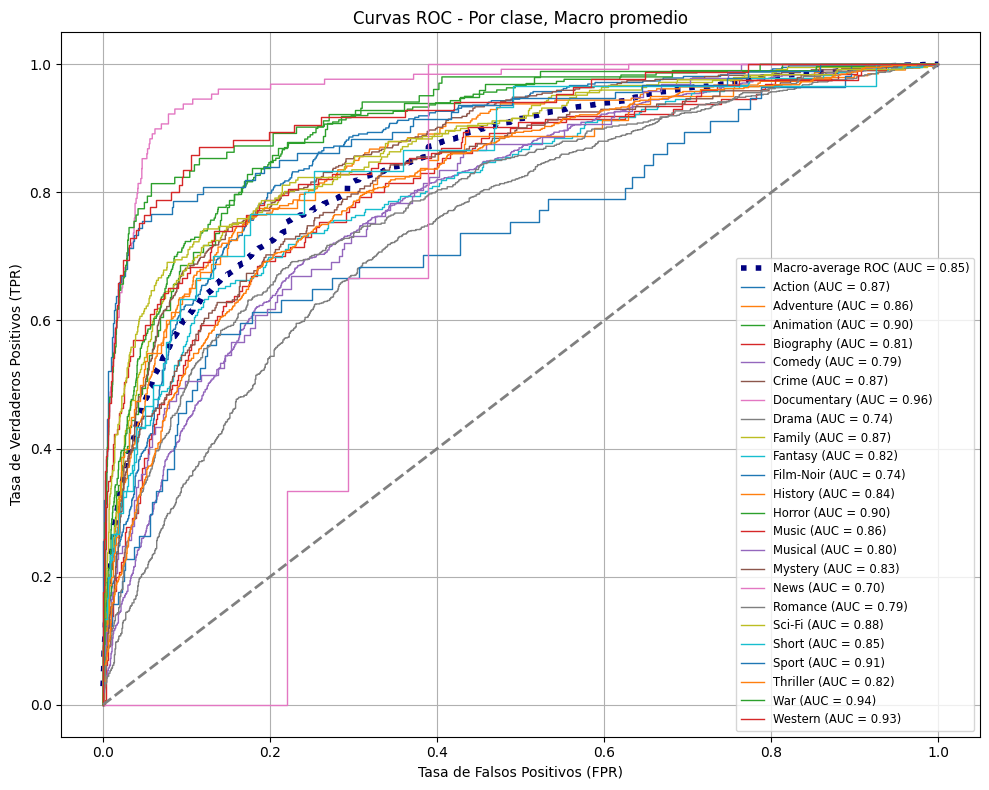

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_val_pred.shape[1]
class_names = mlb.classes_

# Por clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro
# 1. Interpolar todas las curvas
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))


plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

# Curvas individuales
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})',
             lw=1)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC - Por clase, Macro promedio')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
res = pd.DataFrame(y_pred_final, index=dataTesting.index, columns=cols)
res.to_csv('pred_tfidf_lr_calibrado_stopwords.csv', index_label='ID')
##Valor Kaggle 0.88606

In [ ]:
%pip install lightgbm


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 15.1 MB/s eta 0:00:00


### LGBM CLASSIFIER

In [ ]:
from lightgbm import LGBMClassifier


pipeline = Pipeline([
    #('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', OneVsRestClassifier(LGBMClassifier(objective='binary',n_jobs=-1, random_state=42)))
])

param_grid = {
    'clf__estimator__num_leaves': [15, 31, 63],
    'clf__estimator__learning_rate': [0.01, 0.05, 0.1],
    'clf__estimator__n_estimators': [20, 50, 100, 300],
    'clf__estimator__boosting_type': ['gbdt', 'dart'],
    #'clf__estimator__objective': ['multiclass']
    #'tfidf__max_features': [5000, 10000, 20000],
    #'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # unigramas, bigramas y trigramas
    #'tfidf__min_df': [1, 2, 3]
}

# 5. Búsqueda con validación cruzada
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)
# 6. Entrenamiento
grid_search.fit(X_train, y_train)
# 7. Mejor modelo
print("Mejores parámetros:")
print(grid_search.best_params_)


# Paso 5: Evaluación
y_pred = grid_search.predict_proba(X_test)
print('ROC AUC (macro):', roc_auc_score(y_test, y_pred, average='macro'))

# Paso 6: Predicciones para Kaggle
X_final = tfidf.transform(dataTesting['plot_lemmatized'])
y_pred_final = grid_search.predict_proba(X_final)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[LightGBM] [Info] Number of positive: 880, number of negative: 4409
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64974
[LightGBM] [Info] Number of data points in the train set: 5289, number of used features: 2547
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166383 -> initscore=-1.611481
[LightGBM] [Info] Start training from score -1.611481
[LightGBM] [Info] Number of positive: 684, number of negative: 4605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64974
[LightGBM] [Info] Number of data points in the train set: 5289, number of used features: 2547
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.129325 -> initscore=-1.906940
[Light

In [ ]:
res = pd.DataFrame(y_pred_final, index=dataTesting.index, columns=cols)
res.to_csv('pred_lgbr.csv', index_label='ID')

In [ ]:
# Convertir resultados del grid en DataFrame
resultslgbr = pd.DataFrame(grid_search.cv_results_)

# Ordenar por la métrica de evaluación (roc_auc en validación)
resultslgbr_sorted = resultslgbr.sort_values(by='mean_test_score', ascending=False)

# Seleccionar los 5 mejores
top5lgbr = resultslgbr_sorted.head(5)


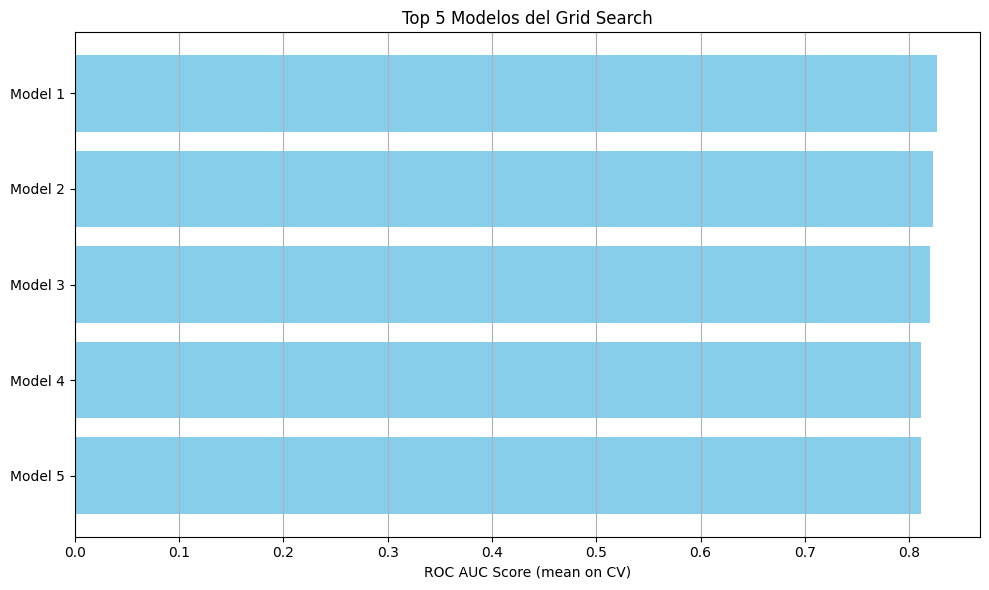

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(range(5), top5lgbr['mean_test_score'], align='center', color='skyblue')
plt.yticks(range(5), [f"Model {i+1}" for i in range(5)])
plt.xlabel('ROC AUC Score (mean on CV)')
plt.title('Top 5 Modelos del Grid Search')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [ ]:
for i, row in top5lgbr.iterrows():
    print(f"\nModelo {i+1} - ROC AUC: {row['mean_test_score']:.4f}")
    for param, value in row.items():
        if param.startswith('param_'):
            print(f"  {param[6:]}: {value}")



Modelo 22 - ROC AUC: 0.8266
  clf__estimator__boosting_type: gbdt
  clf__estimator__learning_rate: 0.05
  clf__estimator__n_estimators: 300
  clf__estimator__num_leaves: 15

Modelo 23 - ROC AUC: 0.8232
  clf__estimator__boosting_type: gbdt
  clf__estimator__learning_rate: 0.05
  clf__estimator__n_estimators: 300
  clf__estimator__num_leaves: 31

Modelo 24 - ROC AUC: 0.8199
  clf__estimator__boosting_type: gbdt
  clf__estimator__learning_rate: 0.05
  clf__estimator__n_estimators: 300
  clf__estimator__num_leaves: 63

Modelo 10 - ROC AUC: 0.8113
  clf__estimator__boosting_type: gbdt
  clf__estimator__learning_rate: 0.01
  clf__estimator__n_estimators: 300
  clf__estimator__num_leaves: 15

Modelo 31 - ROC AUC: 0.8112
  clf__estimator__boosting_type: gbdt
  clf__estimator__learning_rate: 0.1
  clf__estimator__n_estimators: 100
  clf__estimator__num_leaves: 15


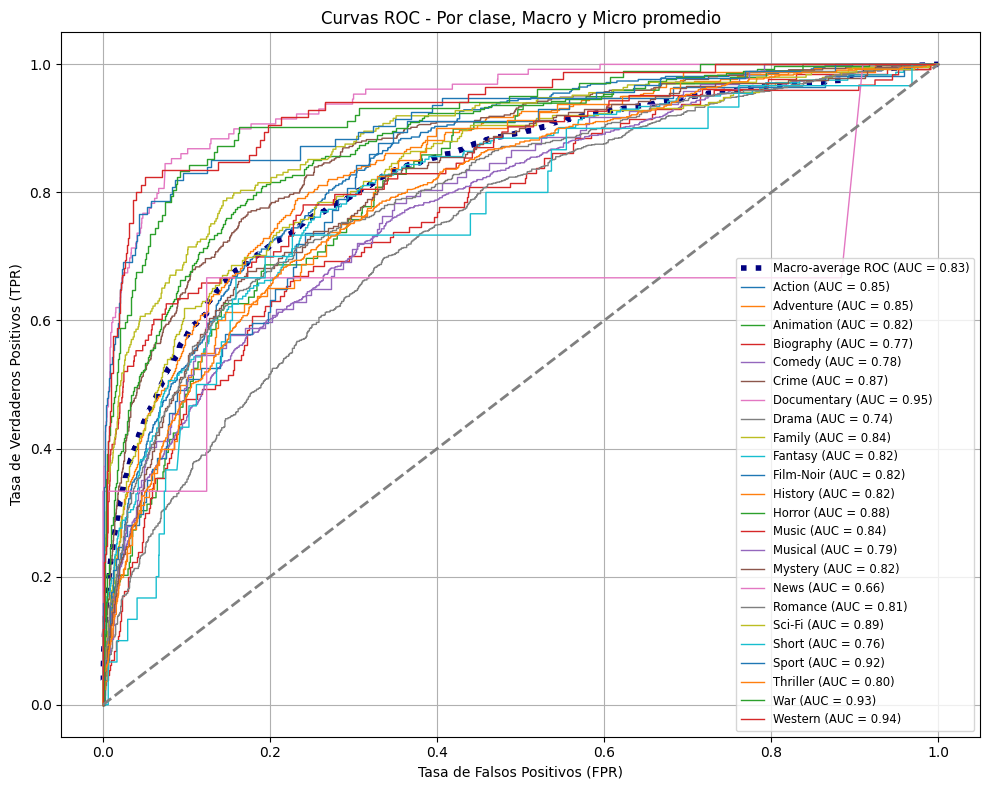

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test.shape[1]
class_names = mlb.classes_

# Por clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro
# 1. Interpolar todas las curvas
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))


plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

# Curvas individuales
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})',
             lw=1)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC - Por clase, Macro y Micro promedio')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

### Redes neuronales

In [ ]:
# Busqueda hiperparametros para modelo TFIDF + Redes Neuronales
def crear_modelo(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_1', min_value=32, max_value=512, step=32), input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    model.add(Dense(hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=[AUC(name='auc_macro', multi_label=True)])
    return model

In [ ]:
## USANDO REDES NEURONALES

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score

# Modelo simple
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenamiento
es = EarlyStopping(patience=3, restore_best_weights=True)
model.fit(X_train.toarray(), y_train,
          validation_split=0.2,
          epochs=20,
          batch_size=64,
          callbacks=[es])

# Evaluación
y_pred = model.predict(X_test.toarray())
print("ROC AUC (macro):", roc_auc_score(y_test, y_pred, average='macro'))


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.1779 - loss: 0.5507 - val_accuracy: 0.2013 - val_loss: 0.2933
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2136 - loss: 0.2924 - val_accuracy: 0.2013 - val_loss: 0.2799
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2692 - loss: 0.2634 - val_accuracy: 0.2410 - val_loss: 0.2511
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.3608 - loss: 0.2173 - val_accuracy: 0.3365 - val_loss: 0.2312
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.4502 - loss: 0.1733 - val_accuracy: 0.3459 - val_loss: 0.2226
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5084 - loss: 0.1380 - val_accuracy: 0.3554 - val_loss: 0.2267
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5193 - loss: 0.1121 - val_accuracy: 0.3573 - val_loss: 0.2363
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5264 - loss: 0.0925 - val_accuracy: 0.3601 - v

In [ ]:
pip install keras-tuner


   ---------------------------------------- 0/2 [kt-legacy]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   -------------------- ------------------- 1/2 [keras-tuner]
   ---------------------------------------- 2/2 [keras-tuner]

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import shutil
import keras_tuner as kt
from tensorflow.keras.metrics import AUC



mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataTraining['genres'])

# Paso 2: TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 1))
X = tfidf.fit_transform(dataTraining['plot'])

# Paso 3: División
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

def crear_modelo(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_1', min_value=32, max_value=512, step=32), input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    model.add(Dense(hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=[AUC(name='auc_macro', multi_label=True)])
    return model

tuner = kt.RandomSearch(
    crear_modelo,
    objective=kt.Objective('val_auc_macro', direction="max"),
    max_trials=20,
    executions_per_trial=1,
    directory='C:/Users/Usuario/Desktop/keras_tuner_dir',
    project_name='yelp_sentiment_tuning'
)


early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

tuner.search(X_train.toarray(), y_train,
             validation_split=0.2,
             epochs=10,
             batch_size=64,
             callbacks=[early_stop],
             verbose=1)

# Mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]
best_params = tuner.get_best_hyperparameters(1)[0]

print("\nMejores hiperparámetros encontrados:")
print(best_params.values)

# Evaluar en test
test_loss, test_acc = best_model.evaluate(X_test.toarray(), y_test, verbose=0)
print(f" Accuracy en test: {test_acc:.4f}")

Trial 20 Complete [00h 00m 20s]
val_auc_macro: 0.667841911315918

Best val_auc_macro So Far: 0.8126267790794373
Total elapsed time: 00h 09m 14s

Mejores hiperparámetros encontrados:
{'units_1': 384, 'dropout_1': 0.30000000000000004, 'units_2': 192, 'dropout_2': 0.2, 'learning_rate': 0.0009953224564196882}
 Accuracy en test: 0.8231


In [ ]:
## cambiar embedings

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D

# Tokenizar
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(dataTraining['plot'])

X_seq = tokenizer.texts_to_sequences(dataTraining['plot'])
X_pad = pad_sequences(X_seq, maxlen=300)

# Igual para test
X_seq_test = tokenizer.texts_to_sequences(dataTesting['plot'])
X_pad_test = pad_sequences(X_seq_test, maxlen=300)
# Dividir en train y val (asegurando que X_pad y y tienen el mismo número de muestras)
X_train, X_val, y_train, y_val = train_test_split(X_pad, y, test_size=0.2, random_state=42)
# Crear el modelo
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=300))
model.add(LSTM(64, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc_macro', multi_label=True)])
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), verbose=1)
# Evaluar el modelo
y_pred = model.predict(X_val)
print("ROC AUC (macro):", roc_auc_score(y_val, y_pred, average='macro'))
# Predecir en el conjunto de test
X_final = tokenizer.texts_to_sequences(dataTesting['plot'])
X_final = pad_sequences(X_final, maxlen=300)
y_pred_final = model.predict(X_final)


Epoch 1/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 185ms/step - auc_macro: 0.5037 - loss: 0.4665 - val_auc_macro: 0.5044 - val_loss: 0.2975
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - auc_macro: 0.5002 - loss: 0.2913 - val_auc_macro: 0.5307 - val_loss: 0.2969
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step - auc_macro: 0.5391 - loss: 0.2914 - val_auc_macro: 0.5941 - val_loss: 0.2921
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - auc_macro: 0.6038 - loss: 0.2846 - val_auc_macro: 0.6254 - val_loss: 0.2860
Epoch 5/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step - auc_macro: 0.6768 - loss: 0.2682 - val_auc_macro: 0.6563 - val_loss: 0.2809
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
ROC AUC (macro): 0.680323476669843
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


In [ ]:
# Guardar predicciones
res = pd.DataFrame(y_pred, index=dataTesting.index, columns=cols)
res.to_csv('pred_lstm.csv', index_label='ID')


### Glove

In [ ]:
## Glove
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import AUC

embedding_index = {}
with open('C:\\Users\\Usuario\\Downloads\\glove.6B\\glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_dim = 100
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(dataTraining['plot'])

X_seq = tokenizer.texts_to_sequences(dataTraining['plot'])
X_pad = pad_sequences(X_seq, maxlen=300)
#dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
#le = MultiLabelBinarizer()
#y_genres = le.fit_transform(dataTraining['genres'])
# Dividir en train y val (asegurando que X_pad y y tienen el mismo número de muestras)
# Igual para test
X_seq_test = tokenizer.texts_to_sequences(dataTesting['plot'])
X_pad_test = pad_sequences(X_seq_test, maxlen=300)
# Dividir en train y val (asegurando que X_pad y y tienen el mismo número de muestras)
X_train, X_val, y_train, y_val = train_test_split(X_pad, y_genres, test_size=0.2, random_state=42)
# Crear el modelo
# Crear la matriz de embeddings
word_index = tokenizer.word_index
num_words = min(20000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model = Sequential()
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=300,
                    trainable=False))  # ❄️ congelar los embeddings
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_genres.shape[1], activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[AUC(name='auc_macro', multi_label=True)])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=64,
                    verbose=1)



Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 202ms/step - auc_macro: 0.5036 - loss: 0.4579 - val_auc_macro: 0.6084 - val_loss: 0.2973
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - auc_macro: 0.5282 - loss: 0.3053 - val_auc_macro: 0.7126 - val_loss: 0.2782
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - auc_macro: 0.6460 - loss: 0.2786 - val_auc_macro: 0.7644 - val_loss: 0.2569
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - auc_macro: 0.7097 - loss: 0.2574 - val_auc_macro: 0.8091 - val_loss: 0.2439
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - auc_macro: 0.7578 - loss: 0.2449 - val_auc_macro: 0.8296 - val_loss: 0.2363
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - auc_macro: 0.7981 - loss: 0.2322 - val_auc_macro: 0.8461 - val_loss: 0.2261
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - auc_macro: 0.8128 - loss: 0.2263 - val_auc_macro: 0.8530 - val_loss: 0.2219
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - auc_macro: 0.8250 - loss: 0.

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

def build_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=num_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=300,
        trainable=hp.Boolean("trainable_embeddings", default=False)
    ))

    model.add(Bidirectional(
        LSTM(units=hp.Int("lstm_units", min_value=32, max_value=128, step=32), return_sequences=True)
    ))

    model.add(GlobalMaxPooling1D())

    model.add(Dense(units=hp.Int("dense_units", 32, 128, step=32), activation='relu'))

    model.add(Dropout(rate=hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(y_genres.shape[1], activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")),
        loss="binary_crossentropy",
        metrics=[AUC(name="auc_macro", multi_label=True)]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_auc_macro", direction="max"),
    max_trials=10,
    executions_per_trial=1,
    directory="C:/Users/Usuario/Desktop/tuner_glove",
    project_name="genre_classification"
)

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_auc_macro", patience=2, mode="max", restore_best_weights=True)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

best_model = tuner.get_best_models(1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Mejores hiperparámetros encontrados:")
print(best_hps.values)

# Evaluación final
val_preds = best_model.predict(X_val)
from sklearn.metrics import roc_auc_score
print("ROC AUC (macro) en validación:", roc_auc_score(y_val, val_preds, average='macro'))
# Predicciones en test
test_preds = best_model.predict(X_pad_test)




Trial 10 Complete [00h 05m 31s]
val_auc_macro: 0.8111448884010315

Best val_auc_macro So Far: 0.8710620999336243
Total elapsed time: 01h 12m 22s
Mejores hiperparámetros encontrados:
{'trainable_embeddings': True, 'lstm_units': 128, 'dense_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0028612572125398966}
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step
ROC AUC (macro) en validación: 0.8740116250731109
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step


In [ ]:
# Guardar predicciones

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

res = pd.DataFrame(test_preds, index=dataTesting.index, columns=cols)
res.to_csv('pred_glove_lstm.csv', index_label='ID')

In [ ]:
import pandas as pd

# Extraer trials como lista
trials = tuner.oracle.trials.values()  # devuelve una lista de Trial objects

# Construir lista de resultados
results = []
for trial in trials:
    result = trial.hyperparameters.values.copy()
    result['val_auc_macro'] = trial.metrics.get_last_value('val_auc_macro')
    results.append(result)

# Convertir a DataFrame
results_df = pd.DataFrame(results)

# Ordenar por val_auc_macro
results_sorted = results_df.sort_values(by='val_auc_macro', ascending=False)

# Top 5
top5 = results_sorted.head(5)
top5


,trainable_embeddings,lstm_units,dense_units,dropout_rate,learning_rate,val_auc_macro
8,True,128,128,0.1,0.002861,0.871062
5,True,64,128,0.4,0.001597,0.859279
1,False,32,96,0.4,0.009066,0.856932
4,True,96,64,0.3,0.003131,0.847562
3,True,128,96,0.3,0.002391,0.844106


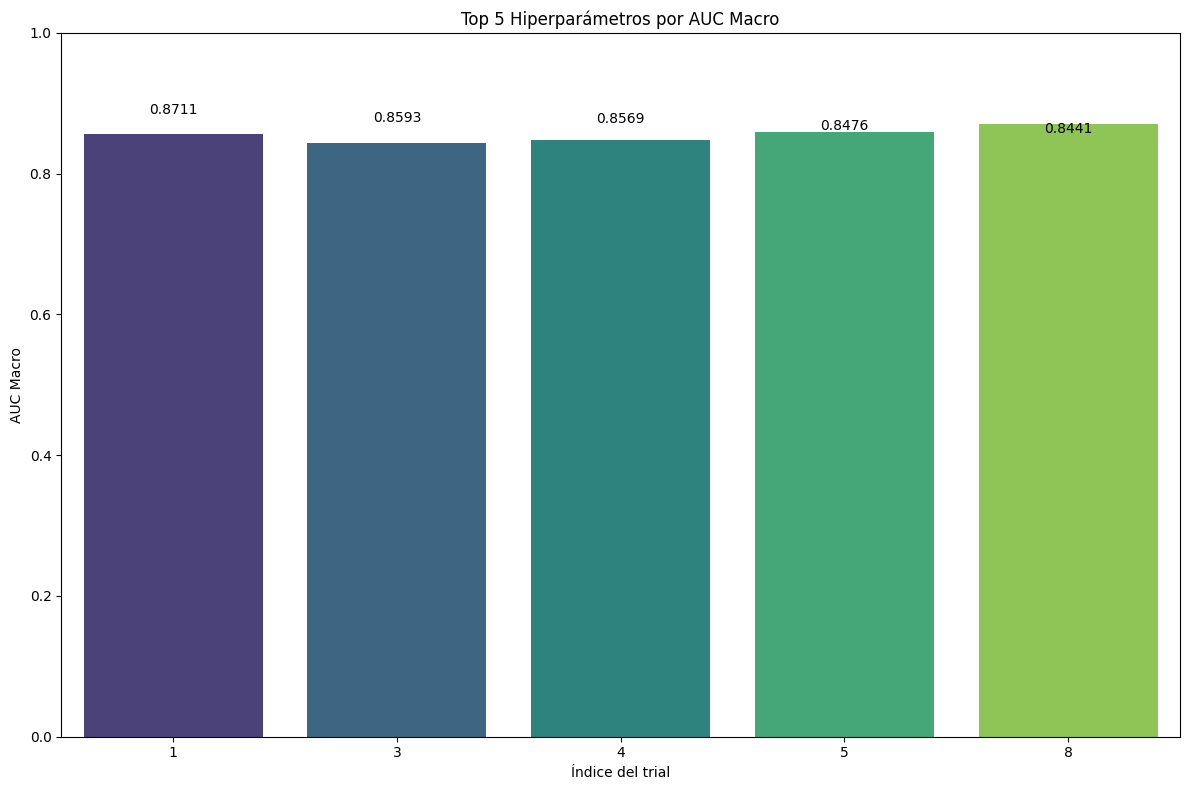

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
top5 = results_sorted.head(5)

# Gráfico de barras
ax = sns.barplot(x=top5.index, y='val_auc_macro', data=top5, palette='viridis')
plt.title('Top 5 Hiperparámetros por AUC Macro')
plt.xlabel('Índice del trial')
plt.ylabel('AUC Macro')
plt.ylim(0, 1)  # Escala fija hasta 1

# Añadir etiquetas encima de las barras
for i, row in enumerate(top5.itertuples()):
    ax.text(i, row.val_auc_macro + 0.01, f"{row.val_auc_macro:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
for i, row in top5.iterrows():
    print(f"\nModelo {i+1} - AUC Macro: {row['val_auc_macro']:.4f}")
    for param, value in row.items():
        if param != 'val_auc_macro':
            print(f"  {param}: {value}")



Modelo 9 - AUC Macro: 0.8711
  trainable_embeddings: True
  lstm_units: 128
  dense_units: 128
  dropout_rate: 0.1
  learning_rate: 0.0028612572125398966

Modelo 6 - AUC Macro: 0.8593
  trainable_embeddings: True
  lstm_units: 64
  dense_units: 128
  dropout_rate: 0.4
  learning_rate: 0.0015973543149091943

Modelo 2 - AUC Macro: 0.8569
  trainable_embeddings: False
  lstm_units: 32
  dense_units: 96
  dropout_rate: 0.4
  learning_rate: 0.009065729012187747

Modelo 5 - AUC Macro: 0.8476
  trainable_embeddings: True
  lstm_units: 96
  dense_units: 64
  dropout_rate: 0.30000000000000004
  learning_rate: 0.0031314126411291264

Modelo 4 - AUC Macro: 0.8441
  trainable_embeddings: True
  lstm_units: 128
  dense_units: 96
  dropout_rate: 0.30000000000000004
  learning_rate: 0.00239138883969472


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step


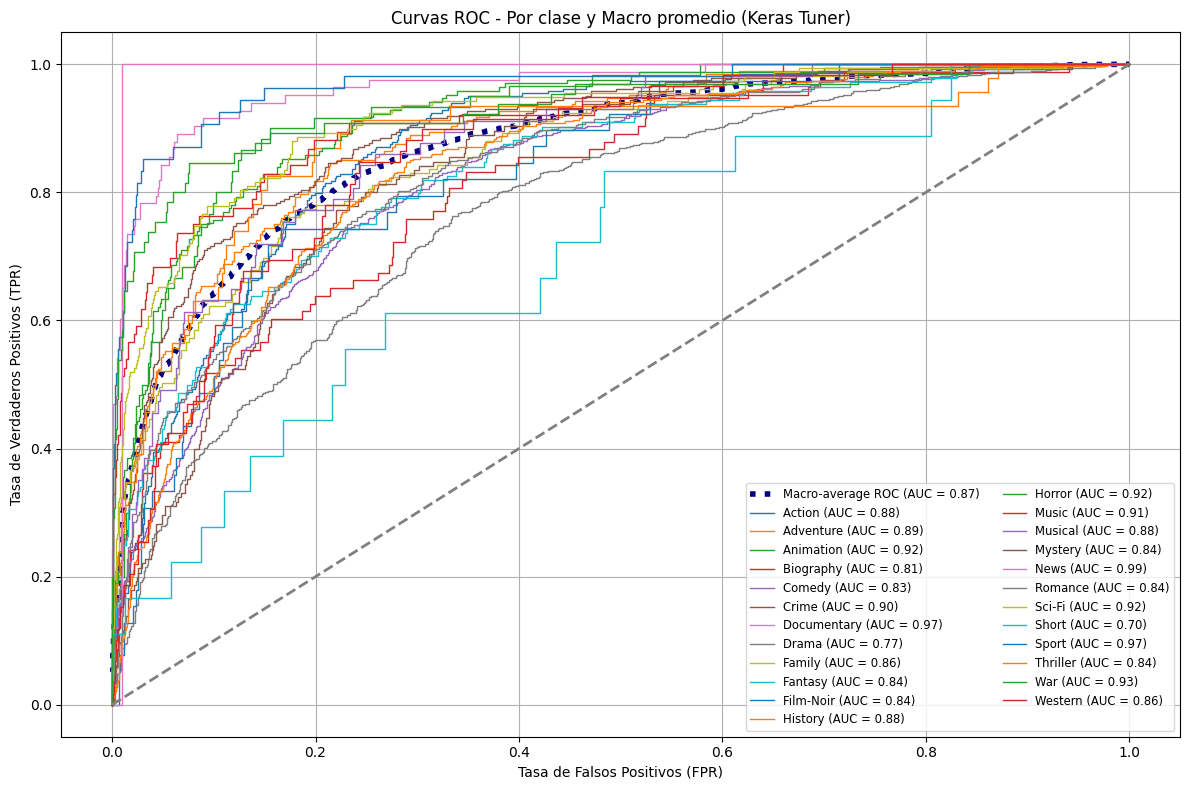

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Asegurarse de que mlb está definido y ajustado
from sklearn.preprocessing import MultiLabelBinarizer
if 'mlb' not in globals():
    mlb = MultiLabelBinarizer()
    mlb.fit(dataTraining['genres'])

# Predecir con el mejor modelo del tuner
y_pred = best_model.predict(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_val.shape[1]
class_names = mlb.classes_

# ROC por clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Gráfico
plt.figure(figsize=(12, 8))

# Macro-average
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

# Curvas por clase (opcional: limitar a top 10)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})',
             lw=1)

# Línea aleatoria
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)

plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC - Por clase y Macro promedio (Keras Tuner)')
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()
